In [ ]:
# we start by loading the dataset, training the network and visualizing the intermediate layers and how they are

In [1]:
import numpy as np
import time
import os
import cv2
import sys

# Now cluster the data

%pylab inline
import os
import keras
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten,Reshape, UpSampling2D, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping



os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac',  'DETRAC-Images')
data_dir

home_dir

filter_path = os.path.join(home_dir, 'filters')
loader_path = os.path.join(home_dir, 'loaders')

sys.path.append(home_dir)
sys.path.append(loader_path)
sys.path.append(filter_path)

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
# Load the data
from loaders.load import Load

start_time = time.time()
load = Load()

eva_dir = home_dir
image_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-data")
anno_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-annotations")

X, length_per_mvi = load.load_images(image_dir, grayscale = False)
Y_dict = load.load_XML(anno_dir, X, length_per_mvi)

print("Total time to load small data is", time.time() - start_time, "seconds")

  0%|          | 0/10421 [00:00<?, ?it/s]

image directory is  /home/jbang36/eva/data/ua_detrac/small-data
Length of file_names: 10421


100%|██████████| 10421/10421 [02:13<00:00, 78.11it/s]
1it [00:00,  2.14it/s]

MVI_20011.xml
mvi length: 664
car_labels length: 664


2it [00:00,  2.30it/s]

MVI_20012.xml
mvi length: 1600
car_labels length: 1600
MVI_20032.xml
mvi length: 2037
car_labels length: 2037


4it [00:01,  2.86it/s]

MVI_20033.xml
mvi length: 2821
car_labels length: 2821


5it [00:01,  2.73it/s]

MVI_20034.xml
mvi length: 3621
car_labels length: 3621


6it [00:02,  2.39it/s]

MVI_20035.xml
mvi length: 4421
car_labels length: 4421


7it [00:02,  2.50it/s]

MVI_20051.xml
mvi length: 5327
car_labels length: 5327


8it [00:02,  2.59it/s]

MVI_20052.xml
mvi length: 6021
car_labels length: 6021


9it [00:03,  2.81it/s]

MVI_20061.xml
mvi length: 6821
car_labels length: 6821


10it [00:03,  3.04it/s]

MVI_20062.xml
mvi length: 7621
car_labels length: 7621


11it [00:03,  3.19it/s]

MVI_20063.xml
mvi length: 8421
car_labels length: 8421


12it [00:04,  2.68it/s]

MVI_20064.xml
mvi length: 9221
car_labels length: 9221


13it [00:04,  2.05it/s]

MVI_20065.xml
mvi length: 10421
car_labels length: 10421
Total time to load small data is 138.3920874595642 seconds


In [3]:
# I am wondering if we downsample and normalize the input early and just apply those images as training, it will affect performance in any way..
# so after running _split_train_test here is the code we should run

# Divide the data into train, test

def _split_train_test(X,Y_dict):
    n_samples, _, _, _= X.shape
    train_index_end = int(len(X) * 0.8)

    X_train = X[:train_index_end]
    X_test = X[train_index_end:]

    Y_dict_train = {}
    Y_dict_test = {}
    for column in Y_dict:
        Y_dict_train[column] = Y_dict[column][:train_index_end]
        Y_dict_test[column] = Y_dict[column][train_index_end:]

    return X_train, X_test, Y_dict_train, Y_dict_test

X_train, X_test, Y_train_dict, Y_test_dict = _split_train_test(X, Y_dict)


X_train_norm = np.copy(X_train)
X_test_norm = np.copy(X_test)

def _format_image(X, sampling_rate=12):
    print("before:", X.shape)
    reduction_rate = sampling_rate
    # need to down shape them so that the kernels can train faster
    # image should be num_samples, height, width, channel
    downsampled_images = X[:, ::reduction_rate, ::reduction_rate, :]
    downsampled_images = downsampled_images.astype(np.float32)
    print("After change, shape of image is", downsampled_images.shape)
    downsampled_images /= 255.0
    return downsampled_images

X_train_norm = _format_image(X_train_norm)
X_test_norm = _format_image(X_test_norm)

before: (8336, 540, 960, 3)
After change, shape of image is (8336, 45, 80, 3)
before: (2085, 540, 960, 3)
After change, shape of image is (2085, 45, 80, 3)


(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


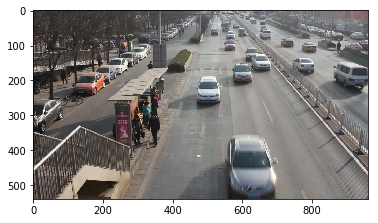

In [4]:
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(X_train[image_index].shape)

example = X_train[image_index]
width, height, channels = example.shape
example = np.squeeze(example)
print(np.squeeze(example).shape)
print(example.shape)

plt.imshow(example)

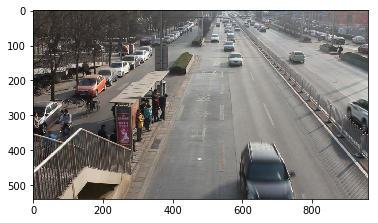

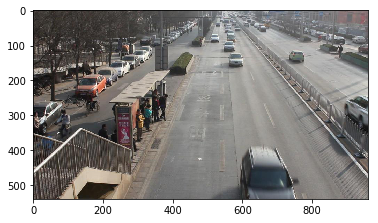

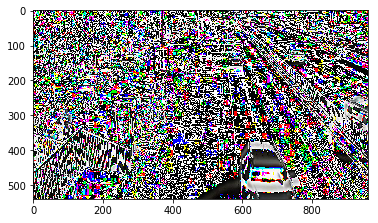

In [9]:
#  I want to try background subtraction

image1 = np.squeeze(X_train[0])
image2 = np.squeeze(X_train[1])
image_sub = image2 - image1
width,height,channels = image_sub.shape


plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

plt.imshow(image_sub)
plt.show()


In [5]:

keras.backend.clear_session()
os.environ["CUDA_VISIBLE_DEVICES"]="0"


In [6]:
# Combined network with both FC and CNN layers

n_samples, width, height, channels = X_train_norm.shape
# Input
input_img = Input(shape=(width, height, 3))
# Encoder
conv1 = Conv2D(8,(3,3),
           activation='relu',
           padding='same')(input_img)
conv2 = Conv2D(8,(3,3),
           activation='relu',
           padding='same')(conv1)
x = MaxPooling2D((2,2),
                 padding='same')(conv2) 
conv3 = Conv2D(16,(3,3),
           activation='relu',
           padding='same')(x)
conv4 = Conv2D(16,(3,3),
           activation='relu',
           padding='same')(conv3)
x = MaxPooling2D((2,2),
                 padding='same')(conv4) # Size 
x = Flatten()(x)
encoded = Dense(256)(x)
# Decoder
x = Dense(3840)(encoded)
x = Reshape((12, 20, 16))(x)
x = UpSampling2D((2, 2))(x) # 24, 40, 16
x = Conv2D(16, (3, 3),
           activation='relu',
           padding='same')(x)
x = Conv2D(16, (3, 3),
           activation='relu',
           padding='same')(x)
x = UpSampling2D((2, 2))(x)  # Size 48, 80, 16
x = Conv2D(8, (3, 3),
           activation='relu',
           padding='same')(x)
x = Conv2D(3, (3, 3),
           activation='relu',
           padding='same')(x)

decoded = Cropping2D(cropping=((2,1),(0,0)),
               data_format='channels_last')(x) # size 45, 80, 16


autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

layers = Model(input_img, [conv1, conv2, conv3, conv4])




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 45, 80, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 80, 8)         224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 80, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 40, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 40, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 40, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 20, 16)        0         
__________

In [7]:
start_time = time.time()
train_history = autoencoder.fit(X_train_norm, X_train_norm, epochs=200, batch_size=2048, validation_data=(X_test_norm, X_test_norm))
print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")

Train on 8336 samples, validate on 2085 samples
Epoch 1/200
8336/8336 [==============================] - 7s 841us/step - loss: 0.1714 - val_loss: 0.0549
Epoch 2/200
8336/8336 [==============================] - 2s 233us/step - loss: 0.0591 - val_loss: 0.0448
Epoch 3/200
8336/8336 [==============================] - 2s 239us/step - loss: 0.0377 - val_loss: 0.0358
Epoch 4/200
8336/8336 [==============================] - 2s 227us/step - loss: 0.0319 - val_loss: 0.0270
Epoch 5/200
8336/8336 [==============================] - 2s 231us/step - loss: 0.0271 - val_loss: 0.0264
Epoch 6/200
8336/8336 [==============================] - 2s 231us/step - loss: 0.0263 - val_loss: 0.0254
Epoch 7/200
8336/8336 [==============================] - 2s 231us/step - loss: 0.0248 - val_loss: 0.0248
Epoch 8/200
8336/8336 [==============================] - 2s 234us/step - loss: 0.0241 - val_loss: 0.0241
Epoch 9/200
8336/8336 [==============================] - 2s 238us/step - loss: 0.0235 - val_loss: 0.0235
Epoch 1

Epoch 78/200
8336/8336 [==============================] - 2s 229us/step - loss: 0.0102 - val_loss: 0.0140
Epoch 79/200
8336/8336 [==============================] - 2s 227us/step - loss: 0.0101 - val_loss: 0.0143
Epoch 80/200
8336/8336 [==============================] - 2s 230us/step - loss: 0.0100 - val_loss: 0.0142
Epoch 81/200
8336/8336 [==============================] - 2s 230us/step - loss: 0.0099 - val_loss: 0.0141
Epoch 82/200
8336/8336 [==============================] - 2s 229us/step - loss: 0.0099 - val_loss: 0.0141
Epoch 83/200
8336/8336 [==============================] - 2s 228us/step - loss: 0.0098 - val_loss: 0.0141
Epoch 84/200
8336/8336 [==============================] - 2s 230us/step - loss: 0.0098 - val_loss: 0.0138
Epoch 85/200
8336/8336 [==============================] - 2s 231us/step - loss: 0.0098 - val_loss: 0.0138
Epoch 86/200
8336/8336 [==============================] - 2s 234us/step - loss: 0.0098 - val_loss: 0.0141
Epoch 87/200
8336/8336 [======================

Epoch 155/200
8336/8336 [==============================] - 2s 230us/step - loss: 0.0081 - val_loss: 0.0131
Epoch 156/200
8336/8336 [==============================] - 2s 231us/step - loss: 0.0081 - val_loss: 0.0132
Epoch 157/200
8336/8336 [==============================] - 2s 229us/step - loss: 0.0081 - val_loss: 0.0134
Epoch 158/200
8336/8336 [==============================] - 2s 234us/step - loss: 0.0080 - val_loss: 0.0133
Epoch 159/200
8336/8336 [==============================] - 2s 230us/step - loss: 0.0080 - val_loss: 0.0131
Epoch 160/200
8336/8336 [==============================] - 2s 229us/step - loss: 0.0081 - val_loss: 0.0138
Epoch 161/200
8336/8336 [==============================] - 2s 224us/step - loss: 0.0081 - val_loss: 0.0132
Epoch 162/200
8336/8336 [==============================] - 2s 220us/step - loss: 0.0080 - val_loss: 0.0131
Epoch 163/200
8336/8336 [==============================] - 2s 232us/step - loss: 0.0079 - val_loss: 0.0132
Epoch 164/200
8336/8336 [============

In [8]:
import h5py

# save the trained model
autoencoder.save('indexing.h5')

In [ ]:
## verify loading the model
from keras.models import load_model
start_time = time.time()
autoencoder = load_model('indexing.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_1').output)
print('Model loaded in: ', time.time() - start_time)

In [15]:
# After training the network to examine the outputs of the layers

outputs = layers.predict(X_train_norm)
activ1 = outputs[0]
activ2 = outputs[1]
activ3 = outputs[2]
activ4 = outputs[3]

print(activ1.shape)
print(activ2.shape)
print(activ3.shape)
print(activ4.shape)




(8336, 45, 80, 8)
(8336, 45, 80, 8)
(8336, 23, 40, 16)
(8336, 23, 40, 16)


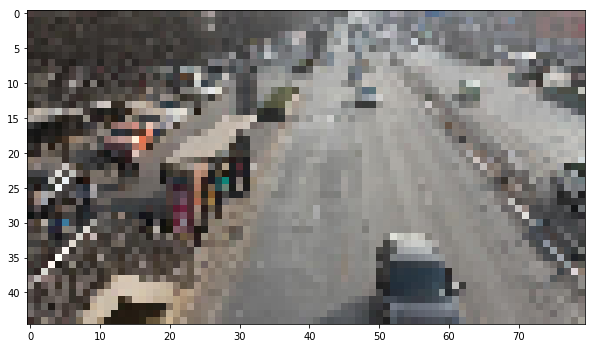

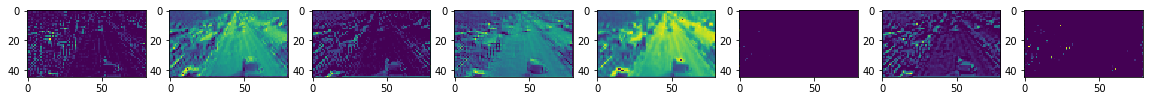

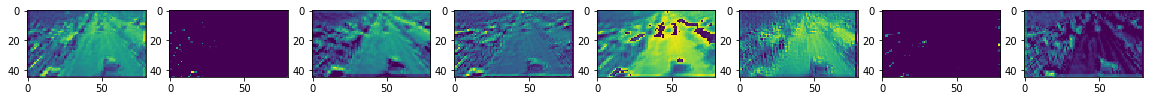

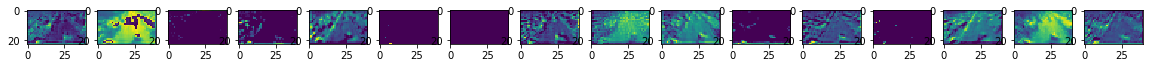

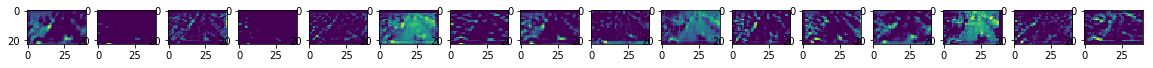

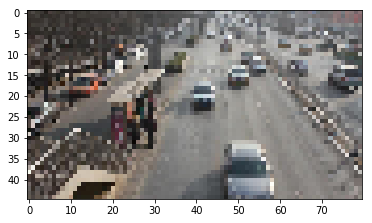

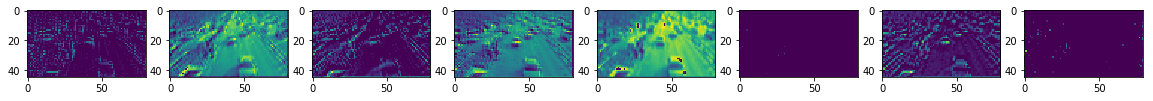

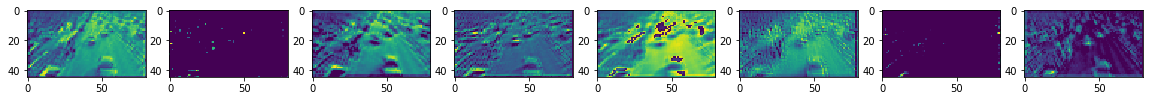

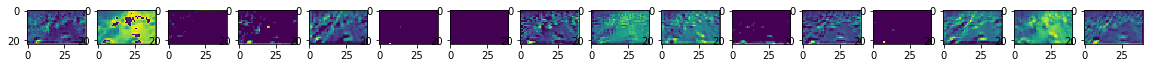

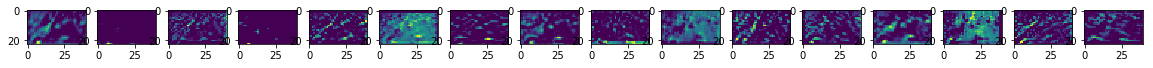

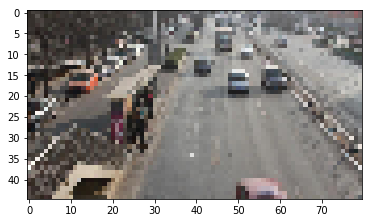

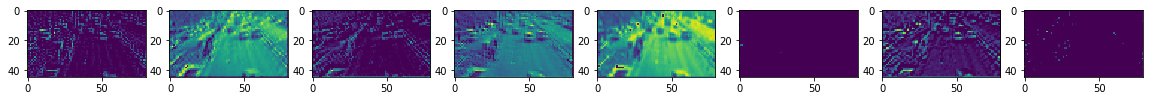

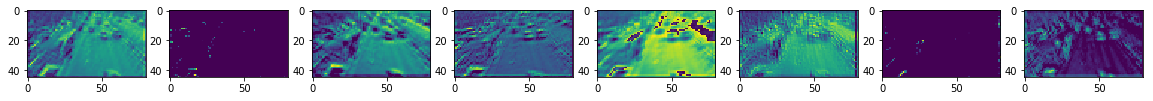

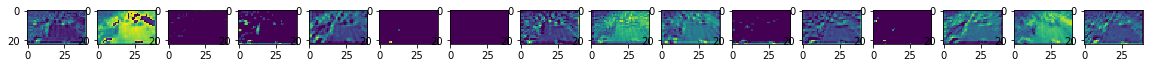

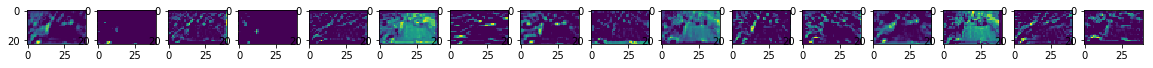

In [29]:
# Get the image and all its features for the first layer

fig=plt.figure(figsize=(10, 10))
columns = 1
rows = 1

image_index = 1
fig.add_subplot(rows, columns, image_index)
image_index += 1

#a = cv2.imread(image)
index_list = [0, 100, 200]
for index in index_list:
    original = np.copy(X_train_norm[index])
    original *= 255.0
    original = original.astype('uint8')

    plt.imshow(original)
    plt.show()

    for activ in [activ1, activ2, activ3, activ4]:
        channels = activ.shape[3]
        fig=plt.figure(figsize=(20, 20))
        columns = channels
        rows = 1

        for channel in range(channels):
            fig.add_subplot(rows, columns, channel + 1)
            image_index += 1
            decoded = np.copy(activ[index,:,:,channel])
            decoded *= 255.0
            decoded = decoded.astype('uint8')
            plt.imshow(decoded)
            #plt.matshow(decoded, cmap='viridis')

        plt.show()






0
(45, 80, 3)
(45, 80, 3)
2
(45, 80, 3)
(45, 80, 3)
4
(45, 80, 3)
(45, 80, 3)
6
(45, 80, 3)
(45, 80, 3)
8
(45, 80, 3)
(45, 80, 3)


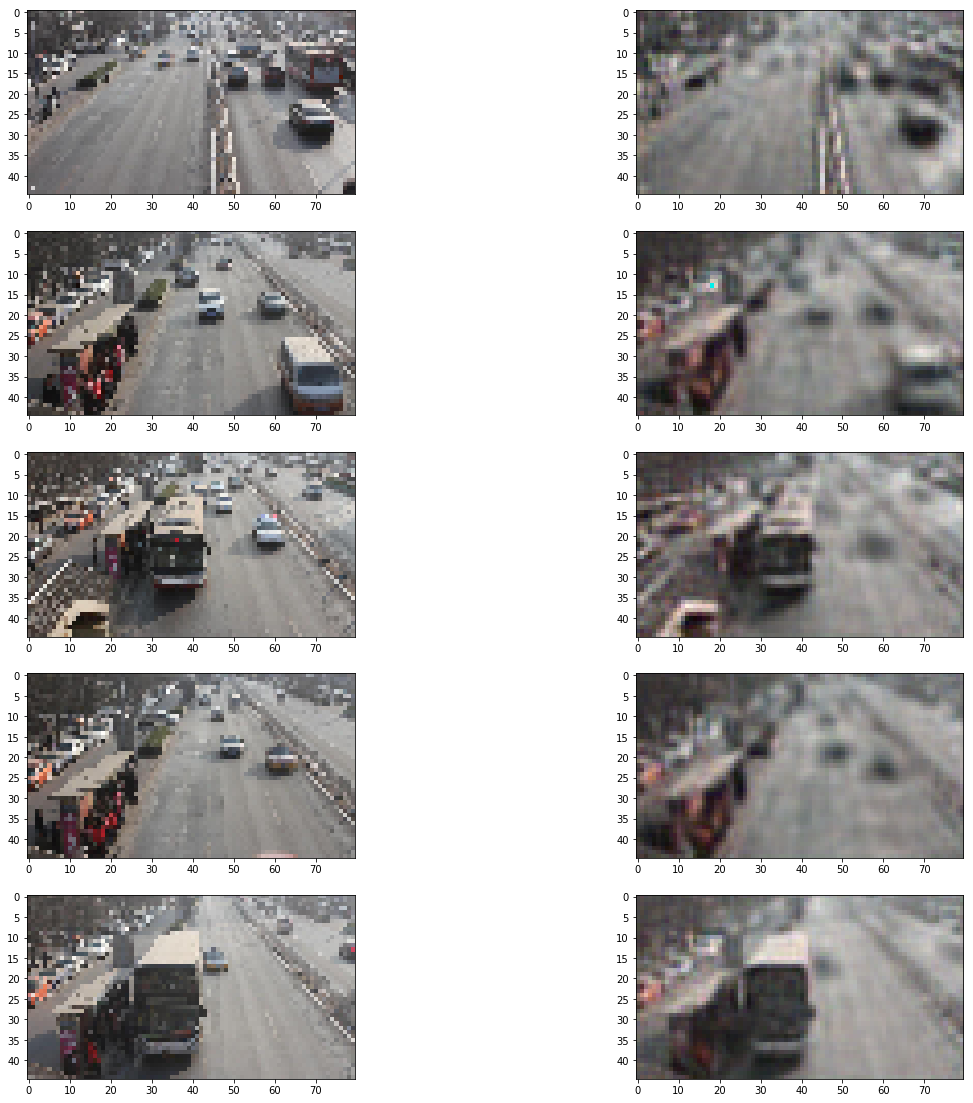

In [12]:
# I also want to visualize the results of decoded images compared with original images

images_decoded = autoencoder.predict(X_train_norm)
image_table = X_train_norm

import matplotlib.pyplot as plt
import random
n_samples, width, height, channels = image_table.shape

fig=plt.figure(figsize=(20, 40))
columns = 2
rows = 10


for idx in range(0, rows, 2):
    fig.add_subplot(rows, columns, idx + 1)
    #a = cv2.imread(image)
    random_index = random.randint(0, len(image_table))
    original = np.copy(image_table[random_index])
    original *= 255.0
    original = original.astype('uint8')
    print(idx)
    #print(original)
    print(original.shape)
    
    plt.imshow(original)
    fig.add_subplot(rows, columns, idx + 2)
    decoded = np.copy(images_decoded[random_index])
    decoded *= 255.0
    decoded = decoded.astype('uint8')
    print(decoded.shape)
    plt.imshow(decoded)
    
plt.show()

In [ ]:
# we don't get patches from the network.... How will we generate patches??
# An idea we can use is to first extract patches.
